# Running a Solver

It is very simple to directly run a solver on a PyCSP$^3$ model. You just have to call the following function:

  *solve()*


This will start the solver ACE on the current problem instance.
The result of this command is the status of the solving operation, which is one of the following constants:
```
  UNSAT
  SAT
  OPTIMUM
  UNKNOWN
```

More specifically, the result is:
- among UNSAT, SAT, and UNKNOWN for a CSP instance
- among UNSAT, SAT, OPTIMUM and UNKNOWN for a COP instance


This function *solve()* accepts several named parameters:
- solver: name of the solver (ACE or CHOCO)
- options: specific options for the solver
- filename: the filename of the compiled problem instance
- verbose: verbosity level from -1 to 2
- sols: number of solutions to be found (ALL if no limit)
- extraction: True if an unsatisfiable core of constraints must be sought

To introduce some illustrations, we need first to import the library PyCSP$^3$:

In [1]:
from pycsp3 import *

As an illustration, let us consider the Warehouse Location Problem (WLP); see the notebook dedicated to this problem for all details. In a first step, we simply consider the decision problem (i.e., the objective is not posted, so, we have a CSP instance). Note that in the model below, we use the function *default_data()* in order to load a JSON file given by an URL. We write:

In [2]:
fixed_cost, capacities, costs = data or default_data("https://www.cril.univ-artois.fr/~lecoutre/Warehouse_example.json")  
nWarehouses, nStores = len(capacities), len(costs)

# w[i] is the warehouse supplying the ith store
w = VarArray(size=nStores, dom=range(nWarehouses))

satisfy(
    # capacities of warehouses must not be exceeded
    Count(w, value=j) <= capacities[j] for j in range(nWarehouses)
);

Then, we run the solver and print the solution if the problem instance is satisfiable (by default, only one solution is sought for a CSP instance). Note that we can display the values assigned to the variables of a specified (possibly multi-dimensional) list by calling the function *values()*.

In [3]:
if solve() is SAT:
    print(values(w)) 

[0, 1, 1, 1, 1, 2, 2, 3, 4, 4]


In a terminal, we could execute a command like this one (with a local data file, that has priority over the default remote one):

The output is not very friendly/readable, but nothing prevents us from improving that aspect. This is what we do now with a Python f-string, getting the value of individual variables with the function *value()*.

In [4]:
if solve() is SAT:
    for i in range(nStores):
        print(f"Warehouse supplying the store {i} is {value(w[i])} with cost {costs[i][value(w[i])]}")

Warehouse supplying the store 0 is 0 with cost 100
Warehouse supplying the store 1 is 1 with cost 27
Warehouse supplying the store 2 is 1 with cost 97
Warehouse supplying the store 3 is 1 with cost 55
Warehouse supplying the store 4 is 1 with cost 96
Warehouse supplying the store 5 is 2 with cost 29
Warehouse supplying the store 6 is 2 with cost 73
Warehouse supplying the store 7 is 3 with cost 43
Warehouse supplying the store 8 is 4 with cost 46
Warehouse supplying the store 9 is 4 with cost 95


Now, we consider the objective function (and so, we have a COP instance). This is the reason why we check if the status returned when calling *solve()* is OPTIMUM. Note that the function *bound()* directly returns the value of the objective function corresponding to the found optimal solution.

In [5]:
minimize(
    # minimizing the overall cost
    Sum(costs[i][w[i]] for i in range(nStores)) + NValues(w) * fixed_cost
)

if solve() is OPTIMUM:
    print(values(w))
    for i in range(nStores):
        print(f"Cost of supplying the store {i} is {costs[i][value(w[i])]}")
    print("Total supplying cost: ", bound())

[4, 1, 4, 0, 4, 1, 1, 2, 1, 2]
Cost of supplying the store 0 is 30
Cost of supplying the store 1 is 27
Cost of supplying the store 2 is 70
Cost of supplying the store 3 is 2
Cost of supplying the store 4 is 4
Cost of supplying the store 5 is 22
Cost of supplying the store 6 is 5
Cost of supplying the store 7 is 13
Cost of supplying the store 8 is 35
Cost of supplying the store 9 is 55
Total supplying cost:  383


One may be worried by the fact that the code mixes modeling and solving parts.
Interestingly, we can make a clear separation as described now. 
First, we write the model in the file 'Warehouse.py':

Then, we write the solving part in a file 'WarehouseSolving.py':

Then, in a terminal, we can execute: 

If for some reasons, it is better to set data in the file containing the solving part, we can modify sys.argv
The file 'WarehouseSolving.py' becomes: 

Then, we can simply execute (do note that the option -data is not used):

As another illustration, let us consider one of the two models, introduced (without variants) for the Queens problem; see the notebook dedicated to this problem for all details.

In [6]:
n = data or 8

# q[i] is the column where is put the ith queen (at row i)
q = VarArray(size=n, dom=range(n))

if not variant():
    satisfy(
        AllDifferent(q),

        # controlling no two queens on the same upward diagonal
        AllDifferent(q[i] + i for i in range(n)),

        # controlling no two queens on the same downward diagonal
        AllDifferent(q[i] - i for i in range(n))
    )

If we write this solving code:

In [7]:
import sys
# or if you want to use pip
!{sys.executable} -m pip install chess.svg

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement chess.svg (from versions: none)
ERROR: No matching distribution found for chess.svg
You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.


In [8]:
import sys
import chess.svg

if solve() is SAT:
    solution = values(q)  # for example: [0, 4, 7, 5, 2, 6, 1, 3]
    board = chess.Board("/".join(("" if v == 0 else str(v)) + "q" + ("" if v == n - 1 else str(n - 1 - v)) for v in solution) + ' b KQkq - 0 1')
    with open('chess.svg', 'w') as f:
        f.write(chess.svg.board(board, size=350))

Then, by means of the package chess.svg, we can generate the rendering of the solution to the 8 queens problem in  a SVG file: 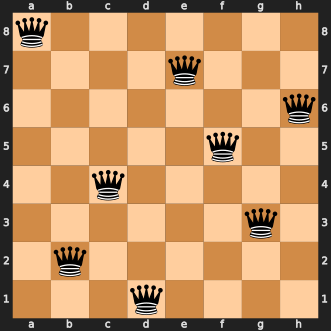